In [1]:
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import ResNet50
from keras.models import Sequential, Model
from keras.layers import *
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from keras.optimizers import Adam
from keras.initializers import glorot_uniform
from keras.utils import plot_model
%matplotlib inline

import data

Using TensorFlow backend.


In [3]:
def ResNet50_custom(input_shape=(64, 64, 3), classes=6):
    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL
    #X = AveragePooling2D((2,2), name="avg_pool")(X)
    #X = Flatten()(X)
    #X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [2]:
def identity_block(X, f, filters, stage, block):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

def convolutional_block(X, f, filters, stage, block, s = 2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage
remove stage 4
// remove stage 5 :
res5a_branch2a
bn
add_16
) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [4]:
model = ResNet50_custom((512, 512, 3))
model.load_weights('/home/rhidra/.keras/models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

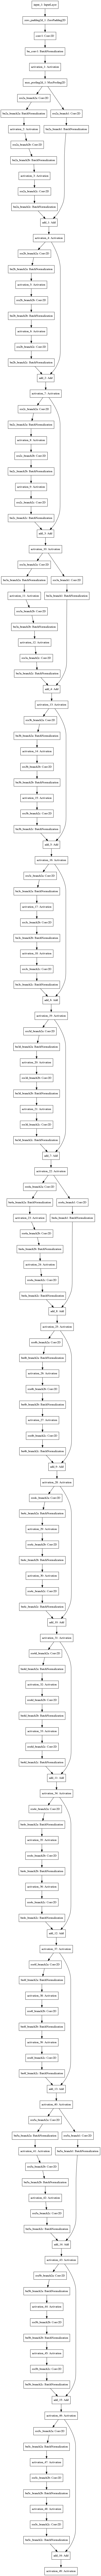

In [5]:
plot_model(model)

In [24]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 256, 256, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [2]:
batch_size = 32
training_size = 2913
testing_size = 210

train_gen = data.data_gen('dataset/images_train', 'dataset/annotations_train', batch_size=batch_size, one_hot=True)
test_gen = data.data_gen('dataset/images_test', 'dataset/annotations_test', batch_size=batch_size, one_hot=True)

In [2]:
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
for layer in resnet.layers:
    layer.trainable = False
    if layer.name == 'activation_71':
        break

/home/rhidra/.local/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [3]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 256, 256, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [3]:
end_stage1 = resnet.get_layer('activation_1').output
end_stage2 = resnet.get_layer('activation_10').output
X = resnet.get_layer('activation_22').output

# Out of ResNet: [64, 64, 512]
X = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
X = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
X = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=0))(X)

X = UpSampling2D(size=2)(X) # Out: [128, 128, 512]
X = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
X = concatenate([end_stage2, X], axis=3)
X = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
X = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=0))(X)

X = UpSampling2D(size=2)(X) # Out: [256, 256, 256]
X = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
X = concatenate([end_stage1, X], axis=3)
X = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
X = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=0))(X)

X = Conv2D(21, 3, activation='softmax', padding='same', kernel_initializer=glorot_uniform(seed=0))(X)

m = Model(inputs=resnet.inputs, outputs=X)
m.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 256, 256, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [4]:
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.backend.sum(y_true_f) + keras.backend.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

model = Sequential()
model.add(resnet)

model.add(Conv2DTranspose(21, 3, strides=2, padding='same'))
model.add(Conv2DTranspose(21, 3, strides=2, padding='same'))
model.add(Conv2DTranspose(21, 3, strides=2, padding='same'))
model.add(Conv2DTranspose(21, 3, strides=2, padding='same'))
model.add(Conv2DTranspose(21, 3, strides=2, padding='same', activation='softmax'))
model.compile(optimizer='adam', loss=dice_coef_loss, metrics=['accuracy'])


In [5]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 16, 16, 2048)      23587712  
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 21)        387093    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 64, 21)        3990      
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 128, 128, 21)      3990      
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 256, 256, 21)      3990      
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 512, 512, 21)      3990      
Total params: 23,990,765
Trainable params: 403,053
Non-trainable params: 23,587,712
____________________________________

In [15]:
img, mask = next(test_gen)

In [32]:
resnet = ResNet50(weights='imagenet', include_top=False)

/home/rhidra/.local/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [33]:
pred = resnet.predict(img[:, :224, :224, :])

In [53]:
pred2 = mod.predict(img[:, :224, :224, :])

In [8]:
pred = model.predict(img[0].reshape(1, 512, 512, 3), verbose=1)

1/1 [==============================] - 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


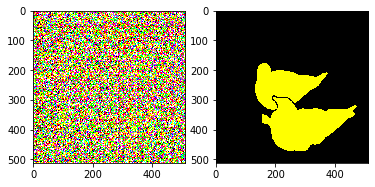

In [9]:
i = pred.reshape(512, 512, 21)
i = np.argmax(i, axis=2)
i = data.mask_class_to_rgb(i)
plt.subplot(121)
plt.imshow(i)
plt.subplot(122)
j = np.argmax(mask[0], axis=2)
plt.imshow(data.mask_class_to_rgb(j))

In [ ]:
results = model.fit_generator(train_gen, epochs=200, steps_per_epoch=training_size // batch_size, verbose=1)

Epoch 1/200


In [ ]:
tf.keras.applications.ResNet50(
    include_top=True, weights='imagenet', input_tensor=None, input_shape=None,
    pooling=None, classes=1000, **kwargs
)

In [6]:
x, y = next(train_gen)

In [23]:
pred = model.predict(x)

In [24]:
y.shape

(32, 512, 512, 21)

In [7]:
result = model.train_on_batch(x, y)

In [4]:
model.summary()

NameError: name 'model' is not defined

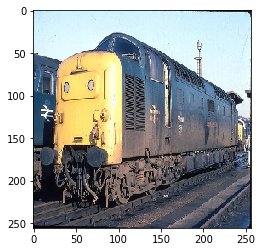

In [37]:
from PIL import Image
img = Image.open('dataset/images_test/005626.jpg')
img = img.convert('RGB')
img = img.resize((256, 256), image.NEAREST)
plt.imshow(np.asarray(img))
plt.savefig('train.jpg', bbox_inches='tight')